# Immage Classification. Simpsons dataset


In this project we will use Immage Classification of characters from Simposns Cartoon.
https://www.kaggle.com/competitions/journey-springfield



In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

9.4.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [5]:
!ls train

simpsons_dataset


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 19 10:36:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

Dataset is presented with 990 pictures. So our goal is to classify them.

In [7]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [8]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [12]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

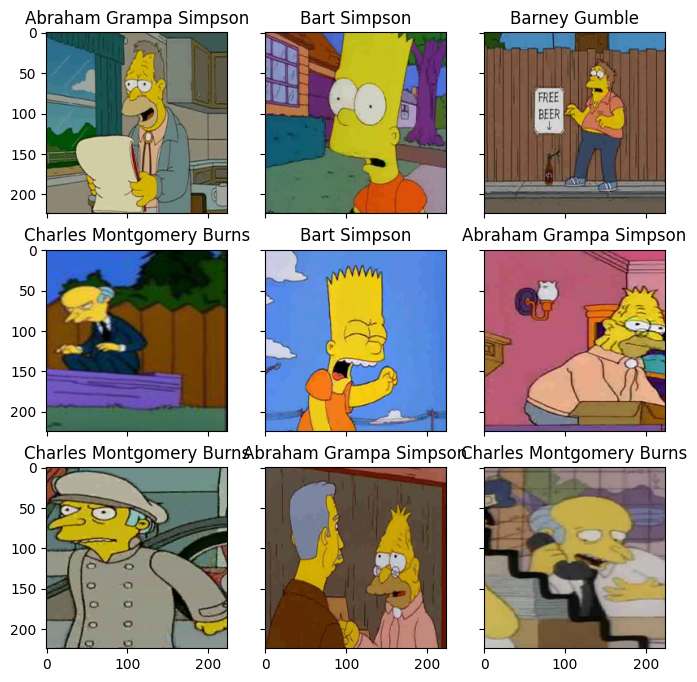

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### SimpleCNN



1. input: 3x224x224
2. 8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. output: 96x5x5


In [17]:

class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [19]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [20]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [21]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [22]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [23]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [24]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.614986508247526


epoch:  50%|█████     | 1/2 [02:26<02:26, 146.27s/it]


Epoch 001 train_loss: 2.6150     val_loss 2.0137 train_acc 0.2738 val_acc 0.4578
loss 1.613843761794058


epoch: 100%|██████████| 2/2 [04:36<00:00, 138.41s/it]


Epoch 002 train_loss: 1.6138     val_loss 1.3630 train_acc 0.5592 val_acc 0.6257


Let's build plot

In [25]:
loss, acc, val_loss, val_acc = zip(*history)

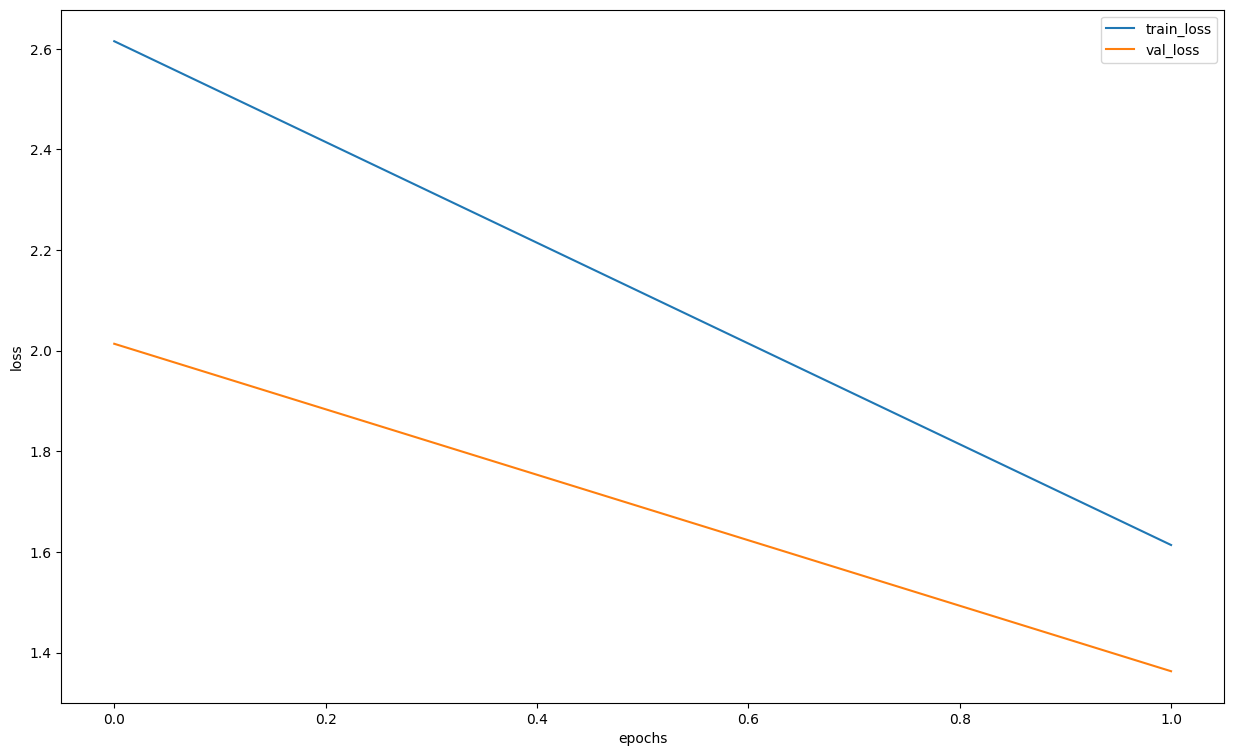

In [26]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### SimpleCNN prediction

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

In [27]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Prediction for 1 picture"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [28]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [29]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [30]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [31]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [32]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.3


Let's check the result

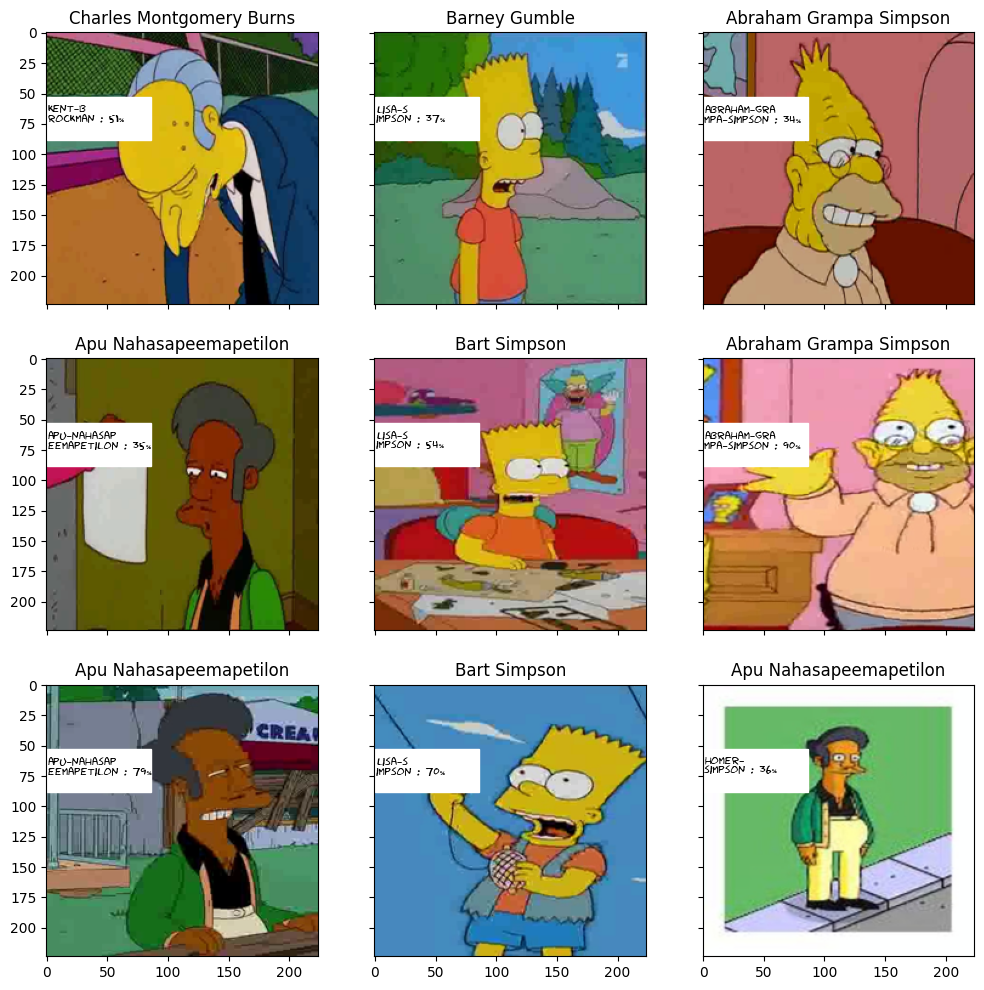

In [33]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Well, it doesn't look good. So let's check other variants of CNN architectures.

# CNN research

## 1. SimpleCnn -> UpgradedCnn


I used Batch normalization.
During tests, I determined that optimal parametrs:

1) numbers of epochs = 5;

2) batch size = 128


Architecture is same as SimpleCNN above:
1. input: 3x224x224
2. 8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. output: 96x5x5


In [39]:
class UpgradedCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)
        self.bn3 = nn.BatchNorm1d(n_classes)
        self.fc2 = nn.Linear(n_classes, 84)
        self.fc3 = nn.Linear(84, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)

        x = self.out(x)
        x = self.bn3(x)
        x = self.fc2(x)
        x = self.fc3(x)


        logits = x
        return logits

In [40]:
def train_upgraded(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [41]:
upgraded_cnn = UpgradedCnn(n_classes).to(DEVICE)

In [42]:
history_upgraded_cnn = train_upgraded(train_dataset, val_dataset, model=upgraded_cnn, epochs=5, batch_size=128)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.1254965965288735


epoch:  20%|██        | 1/5 [02:12<08:50, 132.65s/it]


Epoch 001 train_loss: 2.1255     val_loss 1.4637 train_acc 0.4818 val_acc 0.6041
loss 1.3359067917128293


epoch:  40%|████      | 2/5 [04:25<06:38, 132.98s/it]


Epoch 002 train_loss: 1.3359     val_loss 1.1192 train_acc 0.6429 val_acc 0.6916
loss 0.9039280728911419


epoch:  60%|██████    | 3/5 [06:41<04:28, 134.40s/it]


Epoch 003 train_loss: 0.9039     val_loss 0.8867 train_acc 0.7499 val_acc 0.7585
loss 0.678713268755773


epoch:  80%|████████  | 4/5 [08:57<02:14, 134.71s/it]


Epoch 004 train_loss: 0.6787     val_loss 0.8707 train_acc 0.8096 val_acc 0.7665
loss 0.5215972231025794


epoch: 100%|██████████| 5/5 [11:10<00:00, 134.02s/it]


Epoch 005 train_loss: 0.5216     val_loss 0.7318 train_acc 0.8514 val_acc 0.8101


In [43]:
loss, acc, val_loss, val_acc = zip(*history_upgraded_cnn)

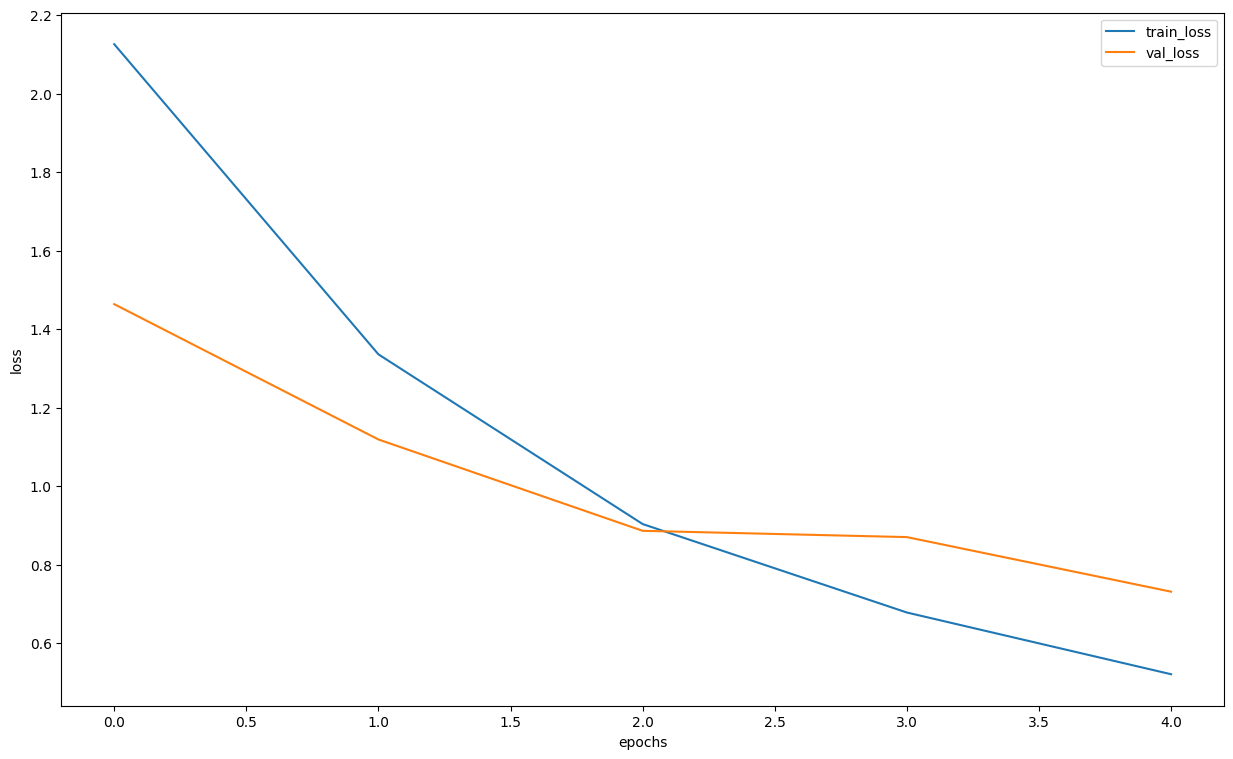

In [44]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Results are much better than previous.

In [45]:

random_characters_up = int(np.random.uniform(0,1000))
ex_img_up, true_label_up = val_dataset[random_characters_up]
probs_im_up = predict_one_sample(upgraded_cnn, ex_img_up.unsqueeze(0))

idxs_up = list(map(int, np.random.uniform(0,1000, 20)))
imgs_up = [val_dataset[id][0].unsqueeze(0) for id in idxs_up]

probs_ims_up = predict(upgraded_cnn, imgs_up)

label_encoder_up = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred_up = np.argmax(probs_ims_up,-1)

actual_labels_up = [val_dataset[id][1] for id in idxs_up]

preds_class_up = [label_encoder_up.classes_[i] for i in y_pred_up]

from sklearn.metrics import f1_score
f1 = f1_score(actual_labels_up, y_pred_up, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.75


In [46]:

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(upgraded_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

#my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [47]:
my_submit.to_csv('colab_upgraded_cnn_baseline(Adam_lr_0.001).csv', index=False)

After Kaggle test F1-score is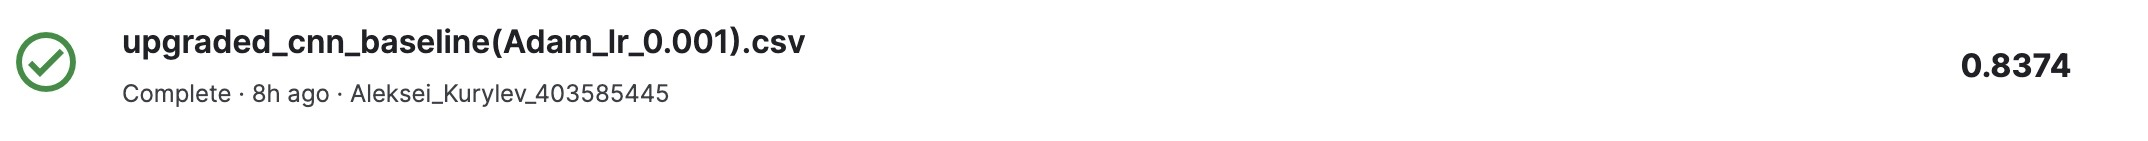

## 2. Other models

### 2.1 AlexNet.

In [48]:
from torchvision import  models
model_alexnet = models.alexnet(pretrained=True).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 89.1MB/s]


In [49]:
history_alexnet= train_upgraded(train_dataset, val_dataset, model=model_alexnet, epochs=5, batch_size=128)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 3.3100547743296196


epoch:  20%|██        | 1/5 [02:11<08:44, 131.07s/it]


Epoch 001 train_loss: 3.3101     val_loss 2.6786 train_acc 0.1324 val_acc 0.2342
loss 2.3261592755523317


epoch:  40%|████      | 2/5 [04:21<06:32, 130.74s/it]


Epoch 002 train_loss: 2.3262     val_loss 1.8289 train_acc 0.3208 val_acc 0.4631
loss 1.6128181733631908


epoch:  60%|██████    | 3/5 [06:32<04:21, 130.68s/it]


Epoch 003 train_loss: 1.6128     val_loss 1.2365 train_acc 0.5388 val_acc 0.6572
loss 1.0894267990510322


epoch:  80%|████████  | 4/5 [08:42<02:10, 130.63s/it]


Epoch 004 train_loss: 1.0894     val_loss 1.0049 train_acc 0.6974 val_acc 0.7325
loss 0.7940257249899644


epoch: 100%|██████████| 5/5 [10:52<00:00, 130.46s/it]


Epoch 005 train_loss: 0.7940     val_loss 0.7877 train_acc 0.7765 val_acc 0.7858


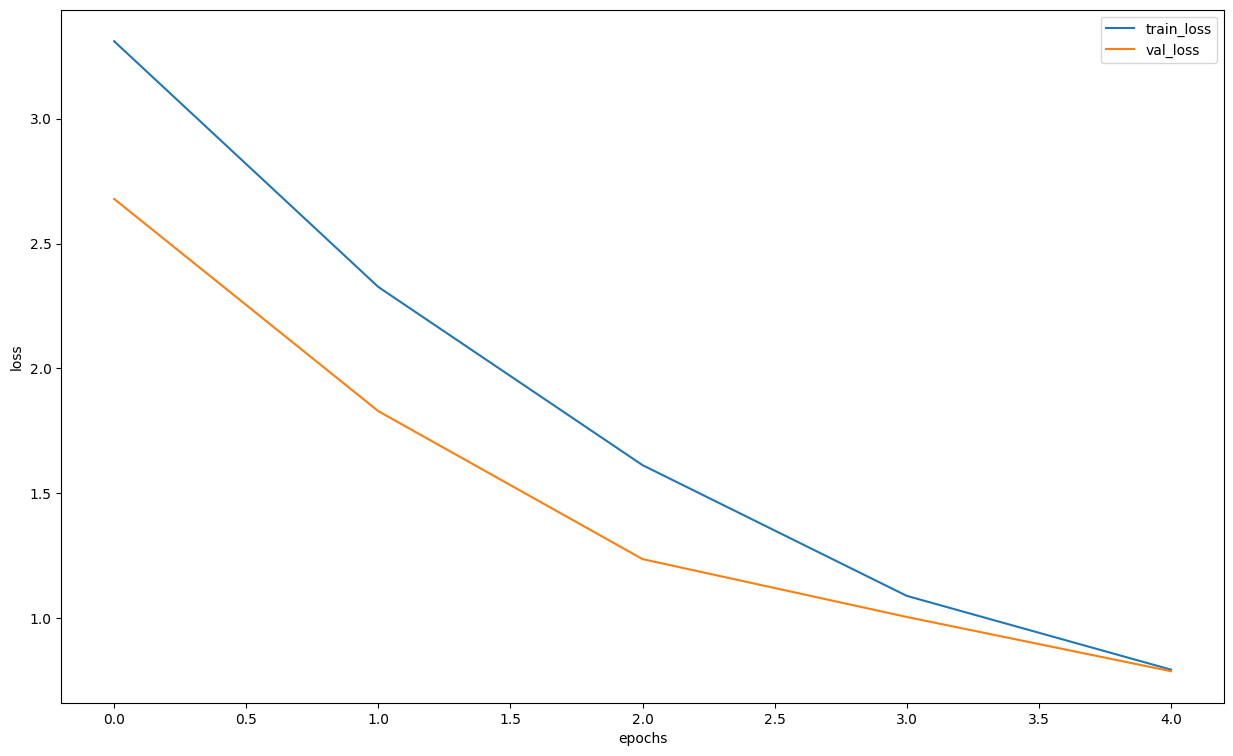

In [50]:
loss, acc, val_loss, val_acc = zip(*history_alexnet)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [73]:
random_characters_alex = int(np.random.uniform(0,1000))
ex_img_alex, true_label_alex = val_dataset[random_characters_alex]
probs_im_alex = predict_one_sample(model_alexnet, ex_img_alex.unsqueeze(0))

idxs_alex = list(map(int, np.random.uniform(0,1000, 20)))
imgs_alex = [val_dataset[id][0].unsqueeze(0) for id in idxs_alex]

probs_ims_alex = predict(model_alexnet, imgs_alex)

label_encoder_alexnet = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred_alex = np.argmax(probs_ims_alex,-1)

actual_labels_alex = [val_dataset[id][1] for id in idxs_alex]

preds_class_alexnet = [label_encoder_alexnet.classes_[i] for i in y_pred_alex]

from sklearn.metrics import f1_score
f1 = f1_score(actual_labels_alex, y_pred_alex, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.75


In [52]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model_alexnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

#my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

#my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [53]:
my_submit.to_csv('colab_alexnet_pretrained.csv', index=False)

After Kaggle test F1-score (AlexNet) is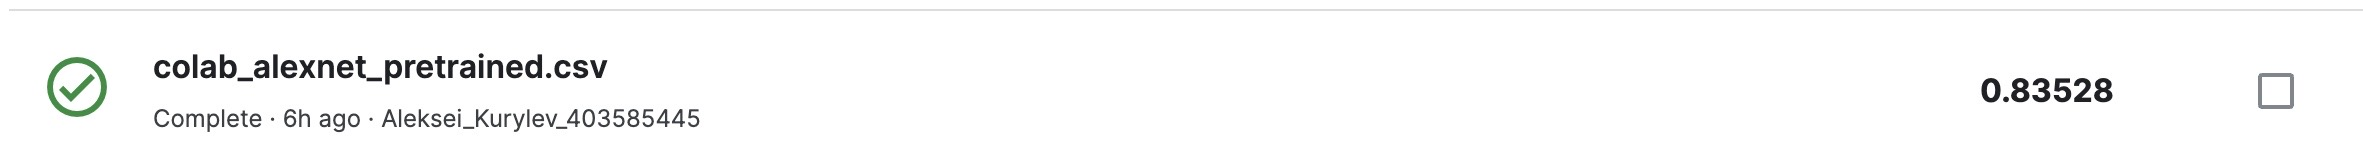

### 2.2 VGG19.

During research we niticed that 5 epochs are not enough for  VGG19 due to overfitting (F1-score(valid sample) = 0,4 )

So let's increase to 25.

In [58]:
model_vgg19 = models.vgg19(pretrained=True).to(DEVICE) 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 150MB/s]


In [59]:
history_vgg19= train_upgraded(train_dataset, val_dataset, model=model_vgg19, epochs=25, batch_size=128)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 3.8434798727673978


epoch:   4%|▍         | 1/25 [03:44<1:29:47, 224.49s/it]


Epoch 001 train_loss: 3.8435     val_loss 3.1056 train_acc 0.0852 val_acc 0.1072
loss 3.105073978782604


epoch:   8%|▊         | 2/25 [07:21<1:24:26, 220.28s/it]


Epoch 002 train_loss: 3.1051     val_loss 2.9294 train_acc 0.1054 val_acc 0.1488
loss 2.6255285378603186


epoch:  12%|█▏        | 3/25 [10:59<1:20:18, 219.04s/it]


Epoch 003 train_loss: 2.6255     val_loss 2.2554 train_acc 0.2471 val_acc 0.3678
loss 2.00721461878923


epoch:  16%|█▌        | 4/25 [14:37<1:16:32, 218.70s/it]


Epoch 004 train_loss: 2.0072     val_loss 1.7124 train_acc 0.4369 val_acc 0.5260
loss 1.5692850922587511


epoch:  20%|██        | 5/25 [18:14<1:12:44, 218.22s/it]


Epoch 005 train_loss: 1.5693     val_loss 1.3951 train_acc 0.5681 val_acc 0.6253
loss 1.2649288538330126


epoch:  24%|██▍       | 6/25 [21:52<1:09:01, 218.00s/it]


Epoch 006 train_loss: 1.2649     val_loss 1.2456 train_acc 0.6523 val_acc 0.6624
loss 1.0003841517609284


epoch:  28%|██▊       | 7/25 [25:29<1:05:20, 217.78s/it]


Epoch 007 train_loss: 1.0004     val_loss 1.1066 train_acc 0.7218 val_acc 0.7044
loss 0.8063593070532412


epoch:  32%|███▏      | 8/25 [29:08<1:01:48, 218.15s/it]


Epoch 008 train_loss: 0.8064     val_loss 0.9265 train_acc 0.7690 val_acc 0.7541
loss 0.6237964995484936


epoch:  36%|███▌      | 9/25 [32:48<58:16, 218.54s/it]


Epoch 009 train_loss: 0.6238     val_loss 0.8896 train_acc 0.8211 val_acc 0.7768
loss 0.46951104832216467


epoch:  40%|████      | 10/25 [36:27<54:39, 218.66s/it]


Epoch 010 train_loss: 0.4695     val_loss 0.8726 train_acc 0.8656 val_acc 0.7864
loss 0.37542124340789196


epoch:  44%|████▍     | 11/25 [40:08<51:12, 219.44s/it]


Epoch 011 train_loss: 0.3754     val_loss 0.9157 train_acc 0.8901 val_acc 0.8059
loss 0.31386198349550004


epoch:  48%|████▊     | 12/25 [43:49<47:40, 220.03s/it]


Epoch 012 train_loss: 0.3139     val_loss 0.9245 train_acc 0.9068 val_acc 0.7839
loss 0.2381009290741009


epoch:  52%|█████▏    | 13/25 [47:29<44:01, 220.09s/it]


Epoch 013 train_loss: 0.2381     val_loss 1.0277 train_acc 0.9282 val_acc 0.7874
loss 0.20492871332002663


epoch:  56%|█████▌    | 14/25 [51:11<40:24, 220.39s/it]


Epoch 014 train_loss: 0.2049     val_loss 1.0000 train_acc 0.9371 val_acc 0.8088
loss 0.13182349814560862


epoch:  60%|██████    | 15/25 [54:51<36:44, 220.46s/it]


Epoch 015 train_loss: 0.1318     val_loss 1.0441 train_acc 0.9581 val_acc 0.8063
loss 0.1489510759825167


epoch:  64%|██████▍   | 16/25 [58:32<33:03, 220.43s/it]


Epoch 016 train_loss: 0.1490     val_loss 1.0664 train_acc 0.9552 val_acc 0.7998
loss 0.11605043951413671


epoch:  68%|██████▊   | 17/25 [1:02:15<29:29, 221.21s/it]


Epoch 017 train_loss: 0.1161     val_loss 1.0540 train_acc 0.9650 val_acc 0.8242
loss 0.09308784961673387


epoch:  72%|███████▏  | 18/25 [1:05:56<25:49, 221.39s/it]


Epoch 018 train_loss: 0.0931     val_loss 1.0574 train_acc 0.9736 val_acc 0.8273
loss 0.10500775669340769


epoch:  76%|███████▌  | 19/25 [1:09:39<22:09, 221.64s/it]


Epoch 019 train_loss: 0.1050     val_loss 1.1702 train_acc 0.9678 val_acc 0.8103
loss 0.07933627338231054


epoch:  80%|████████  | 20/25 [1:13:23<18:31, 222.38s/it]


Epoch 020 train_loss: 0.0793     val_loss 1.2176 train_acc 0.9773 val_acc 0.8235
loss 0.08627791096649091


epoch:  84%|████████▍ | 21/25 [1:17:04<14:47, 221.96s/it]


Epoch 021 train_loss: 0.0863     val_loss 1.1686 train_acc 0.9760 val_acc 0.8093
loss 0.07888408808765066


epoch:  88%|████████▊ | 22/25 [1:20:45<11:05, 221.84s/it]


Epoch 022 train_loss: 0.0789     val_loss 1.2635 train_acc 0.9773 val_acc 0.8017
loss 0.08444160220278313


epoch:  92%|█████████▏| 23/25 [1:24:26<07:23, 221.67s/it]


Epoch 023 train_loss: 0.0844     val_loss 1.0081 train_acc 0.9761 val_acc 0.8355
loss 0.09000475987620214


epoch:  96%|█████████▌| 24/25 [1:28:05<03:40, 220.62s/it]


Epoch 024 train_loss: 0.0900     val_loss 1.0590 train_acc 0.9749 val_acc 0.8131
loss 0.07842790415385124


epoch: 100%|██████████| 25/25 [1:31:46<00:00, 220.25s/it]


Epoch 025 train_loss: 0.0784     val_loss 1.0260 train_acc 0.9771 val_acc 0.8256


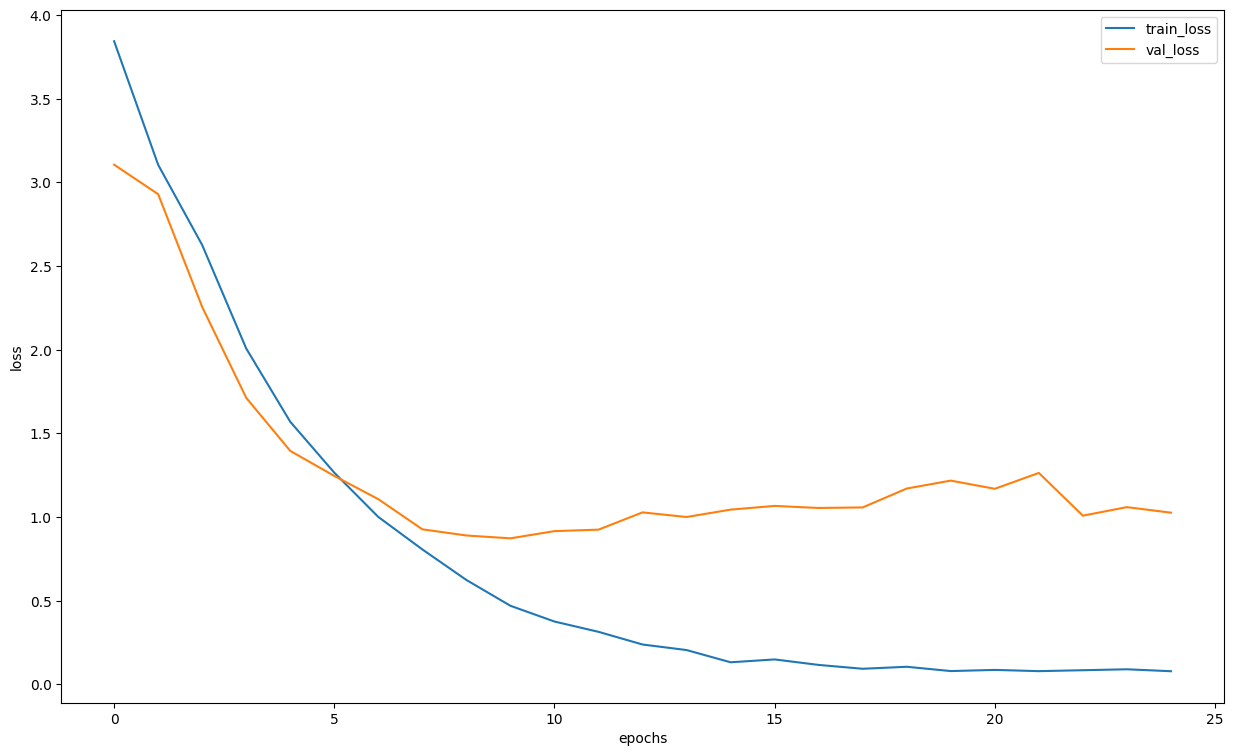

In [60]:
loss, acc, val_loss, val_acc = zip(*history_vgg19)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


In [61]:
random_characters_vgg19 = int(np.random.uniform(0,1000))
ex_img_vgg19, true_label_vgg19 = val_dataset[random_characters_vgg19]
probs_im_vgg19 = predict_one_sample(model_vgg19, ex_img_vgg19.unsqueeze(0))

idxs_vgg19 = list(map(int, np.random.uniform(0,1000, 20)))
imgs_vgg19 = [val_dataset[id][0].unsqueeze(0) for id in idxs_vgg19]

probs_ims_vgg19 = predict(model_vgg19, imgs_vgg19)

label_encoder_vgg19 = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred_vgg19 = np.argmax(probs_ims_vgg19,-1)

actual_labels_vgg19 = [val_dataset[id][1] for id in idxs_vgg19]

preds_class_vgg19 = [label_encoder_vgg19.classes_[i] for i in y_pred_vgg19]

from sklearn.metrics import f1_score
f1 = f1_score(actual_labels_vgg19, y_pred_vgg19, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.9500000000000001


In [68]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model_vgg19, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

#my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

#my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [70]:
my_submit.to_csv('colab_vgg19_pretrained.csv', index=False)

VGG19 preformed best result. F1-score(test sample) 0,93623.
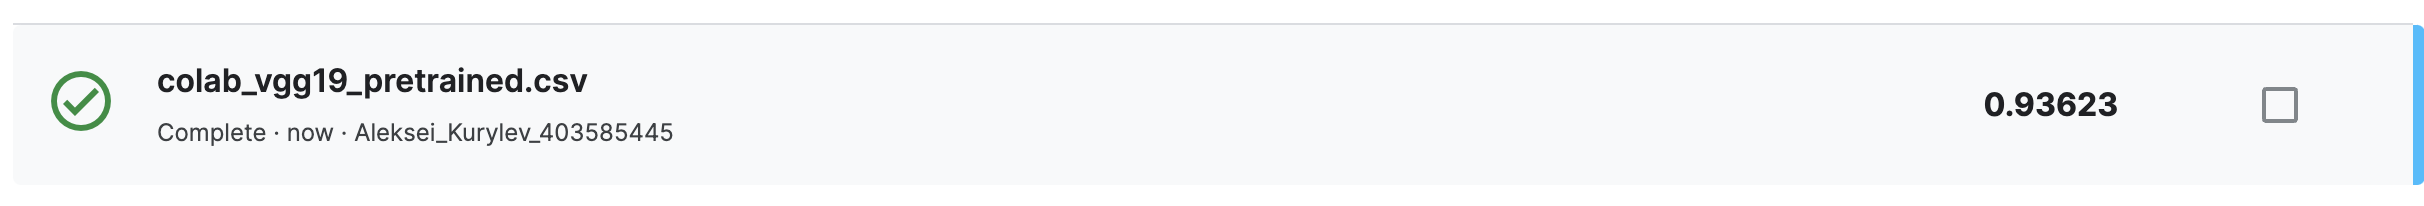